# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
images = dict()

# Função para leitura dos espectros

In [3]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

# Arquivos de entrada

In [4]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()


for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('./Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


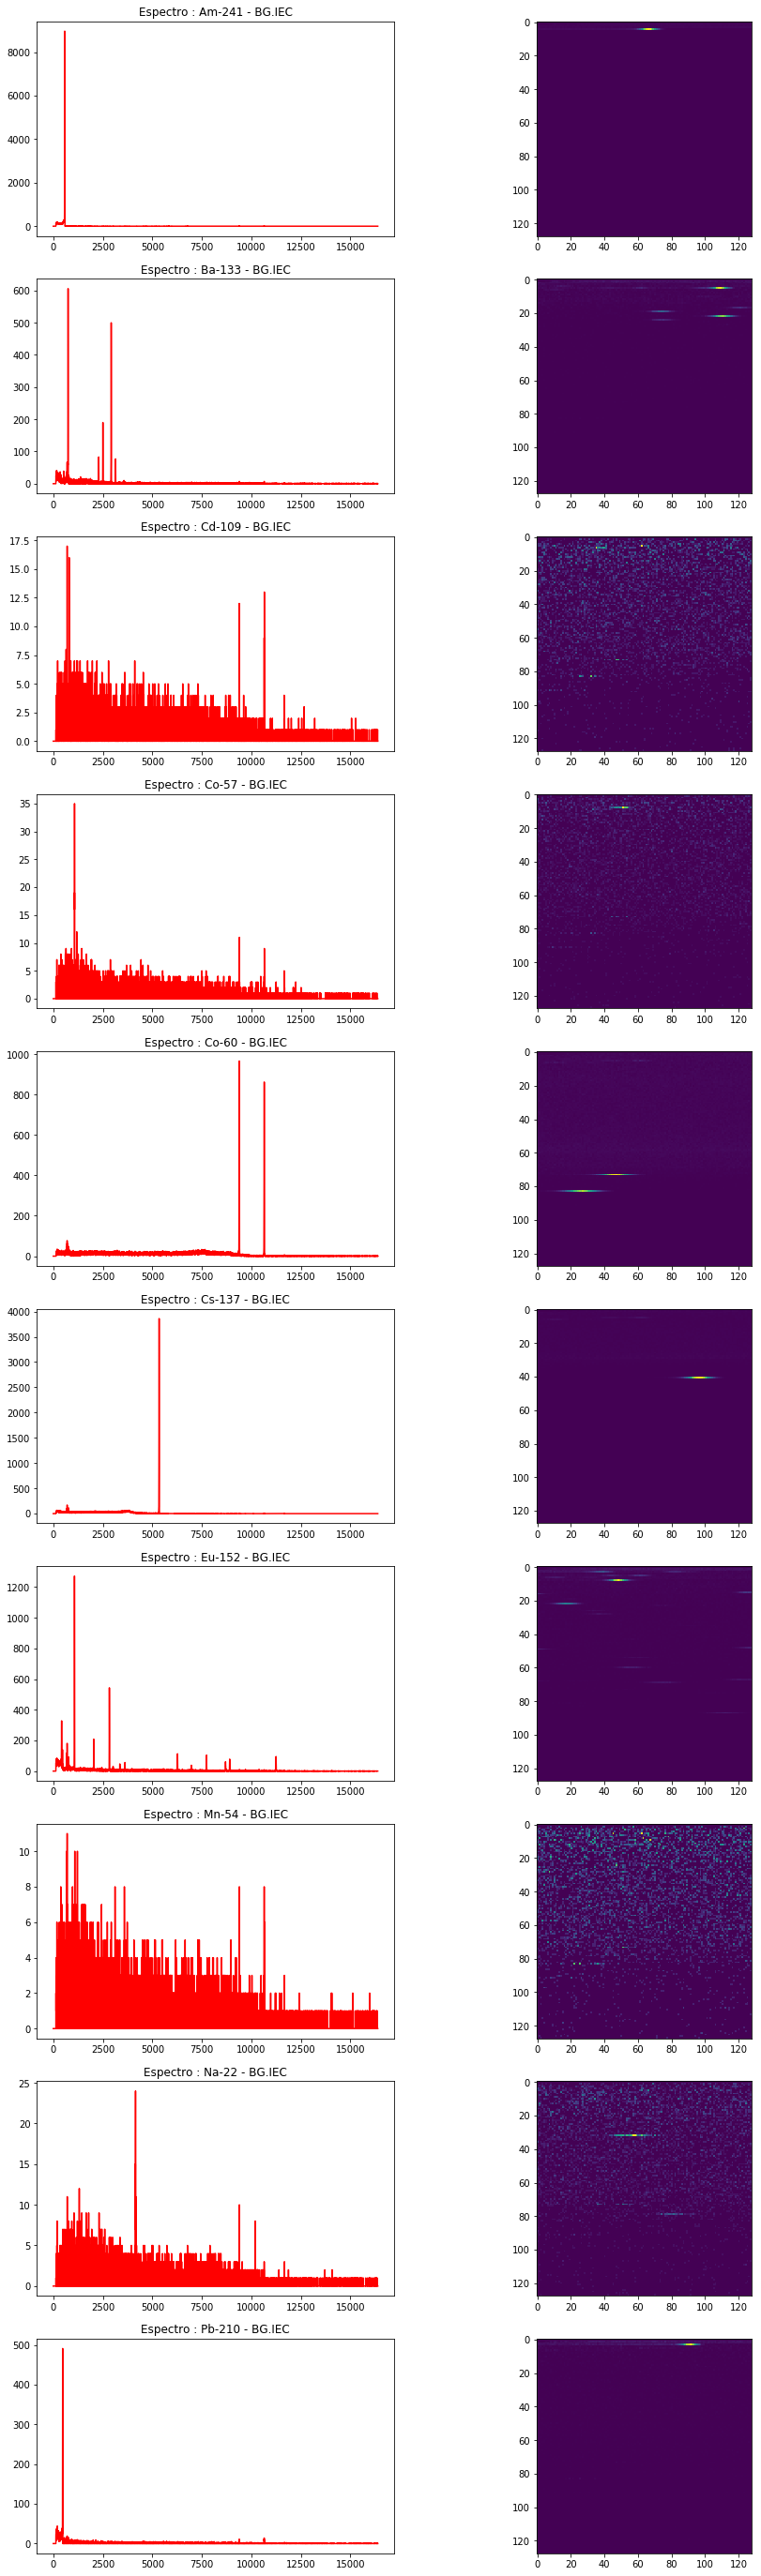

In [5]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

# Rede neural para classificação

Precisamos criar os seguntes componentes:

- Gerador de Imagens : para alimentar a rede neural com os espectros acima adicionando algum ruido Gaussiano

- Rede Neural VGG 16 com 1 saídas possiveis: [COLOCA A LISTA AQUI!]

Depois procedemos com o treino e com a validação.


In [6]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [7]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo

In [8]:
def gera_imagem_combinada(dicionario_imagens,
                          n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    label = np.sum([to_categorical(x, 10) for x in a], axis=0)
    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a], axis=0)
    
    return img, label

In [9]:
def gerador_imagens(dicionario_imagens, batch_size):
    categorias = list(dicionario_imagens.keys())
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size):
            img, label = gera_imagem_combinada(dicionario_imagens, np.random.randint(1, 4))
            x_batch.append(img)
            y_batch.append(label)
        yield np.array(x_batch, np.float32), np.array(y_batch, np.uint8)

In [10]:
gen = gerador_imagens(images, batch_size=8)

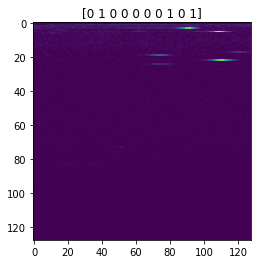

In [11]:
a, b = gen.__next__()
plt.imshow(a[0].reshape((128, 128)))
plt.title(str(b[0]))
plt.show()

In [66]:
learning_rate = 1e-3
epochs = 250
steps_per_epoch = 500
validation_steps = 80

In [67]:
def accuracy_score_wrapper(label, pred):
    threshold = .5
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

In [105]:
def my_accuracy_score(label, pred):
    metric_value = tf.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [132]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False, weights=None, input_shape=(128, 128, 1), classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(10, activation='sigmoid', name="predictions")(x)

model = keras.models.Model(vgg_model.input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [113]:
#K.clear_session()
#model = VGG16(include_top=False, weights=None, input_shape=(128, 128, 1), classes=10)
#model.summary()
#opt = SGD(lr=learning_rate, nesterov=True, momentum=0.9)

In [70]:
#model.get_layer("predictions").activation = keras.activations.sigmoid

In [134]:
opt = SGD(lr=learning_rate) #, nesterov=True, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[my_accuracy_score])

In [0]:
#from IPython.display import SVG
#from keras.utils import plot_model
#from keras.utils.vis_utils import model_to_dot
#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [135]:
def step_decay(epoch):
    initial_lrate = learning_rate
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    print(lrate)
    return np.round(lrate)

callbacks = [] #[LearningRateScheduler(step_decay)]

gerador_treino = gerador_imagens(images, batch_size=8)
gerador_validacao = gerador_imagens(images, batch_size=8)


hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=1,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps)

Epoch 1/250
500/500 [==============================] - 57s 115ms/step - loss: 0.5489 - my_accuracy_score: 0.0970 - val_loss: 0.4466 - val_my_accuracy_score: 0.1656
Epoch 2/250
500/500 [==============================] - 55s 110ms/step - loss: 0.3924 - my_accuracy_score: 0.2108 - val_loss: 0.3855 - val_my_accuracy_score: 0.1750
Epoch 3/250
500/500 [==============================] - 58s 115ms/step - loss: 0.3443 - my_accuracy_score: 0.2500 - val_loss: 0.3273 - val_my_accuracy_score: 0.3031
Epoch 4/250
500/500 [==============================] - 58s 116ms/step - loss: 0.3193 - my_accuracy_score: 0.2748 - val_loss: 0.3030 - val_my_accuracy_score: 0.3063
Epoch 5/250
500/500 [==============================] - 58s 116ms/step - loss: 0.2946 - my_accuracy_score: 0.2815 - val_loss: 0.2655 - val_my_accuracy_score: 0.3484
Epoch 6/250
500/500 [==============================] - 58s 116ms/step - loss: 0.2682 - my_accuracy_score: 0.2988 - val_loss: 0.2633 - val_my_accuracy_score: 0.2750
Epoch 7/250
500/

Epoch 51/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1150 - my_accuracy_score: 0.5627 - val_loss: 0.1085 - val_my_accuracy_score: 0.5672
Epoch 52/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1111 - my_accuracy_score: 0.5727 - val_loss: 0.1121 - val_my_accuracy_score: 0.5781
Epoch 53/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1092 - my_accuracy_score: 0.5905 - val_loss: 0.0955 - val_my_accuracy_score: 0.6250
Epoch 54/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1081 - my_accuracy_score: 0.5805 - val_loss: 0.1054 - val_my_accuracy_score: 0.6453
Epoch 55/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1070 - my_accuracy_score: 0.5872 - val_loss: 0.1047 - val_my_accuracy_score: 0.6219
Epoch 56/250
500/500 [==============================] - 55s 110ms/step - loss: 0.1022 - my_accuracy_score: 0.6120 - val_loss: 0.0977 - val_my_accuracy_score: 0.6594
Epoch 57/2

500/500 [==============================] - 55s 110ms/step - loss: 0.0069 - my_accuracy_score: 0.9778 - val_loss: 0.0082 - val_my_accuracy_score: 0.9703
Epoch 150/250
500/500 [==============================] - 55s 110ms/step - loss: 0.0065 - my_accuracy_score: 0.9788 - val_loss: 0.0065 - val_my_accuracy_score: 0.9797
Epoch 151/250
500/500 [==============================] - 55s 110ms/step - loss: 0.0064 - my_accuracy_score: 0.9792 - val_loss: 0.0054 - val_my_accuracy_score: 0.9797
Epoch 152/250
500/500 [==============================] - 55s 110ms/step - loss: 0.0071 - my_accuracy_score: 0.9765 - val_loss: 0.0064 - val_my_accuracy_score: 0.9750
Epoch 153/250
500/500 [==============================] - 55s 110ms/step - loss: 0.0069 - my_accuracy_score: 0.9773 - val_loss: 0.0171 - val_my_accuracy_score: 0.9391
Epoch 154/250
500/500 [==============================] - 55s 110ms/step - loss: 0.0107 - my_accuracy_score: 0.9692 - val_loss: 0.0064 - val_my_accuracy_score: 0.9781
Epoch 155/250
500/

500/500 [==============================] - 55s 110ms/step - loss: 5.6701e-04 - my_accuracy_score: 0.9987 - val_loss: 4.0840e-04 - val_my_accuracy_score: 1.0000
Epoch 247/250
500/500 [==============================] - 55s 110ms/step - loss: 3.1602e-04 - my_accuracy_score: 0.9998 - val_loss: 2.1033e-04 - val_my_accuracy_score: 1.0000
Epoch 248/250
500/500 [==============================] - 55s 110ms/step - loss: 9.6049e-04 - my_accuracy_score: 0.9978 - val_loss: 8.8569e-04 - val_my_accuracy_score: 0.9984
Epoch 249/250
500/500 [==============================] - 55s 110ms/step - loss: 3.1505e-04 - my_accuracy_score: 1.0000 - val_loss: 2.6116e-04 - val_my_accuracy_score: 1.0000
Epoch 250/250
500/500 [==============================] - 55s 110ms/step - loss: 7.0893e-04 - my_accuracy_score: 0.9985 - val_loss: 0.0015 - val_my_accuracy_score: 0.9953


In [137]:
from keras.models import save_model
save_model(model, 'v1-VGG-19-SGD-sigmoid.hdf5')

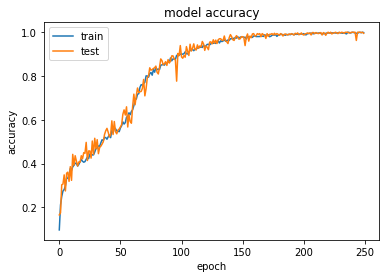

In [138]:
plt.plot(hist.history['my_accuracy_score'])
plt.plot(hist.history['val_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

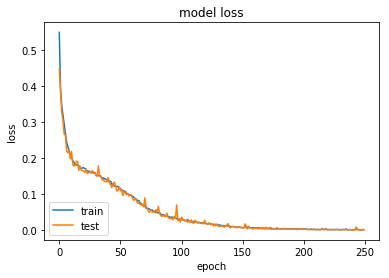

In [139]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

In [167]:
pred = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
0,Am-241,99.9999%
9,Pb-210,0.0069%
5,Cs-137,0.0025%
6,Eu-152,0.0014%
1,Ba-133,0.0009%
8,Na-22,0.0002%
4,Co-60,0.0000%
3,Co-57,0.0000%
7,Mn-54,0.0000%
2,Cd-109,0.0000%


In [168]:
pred = model.predict(np.array([images['Ba-133'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
1,Ba-133,100.0000%
6,Eu-152,0.0685%
9,Pb-210,0.0206%
5,Cs-137,0.0038%
0,Am-241,0.0025%
4,Co-60,0.0010%
3,Co-57,0.0006%
2,Cd-109,0.0000%
8,Na-22,0.0000%
7,Mn-54,0.0000%


In [169]:
pred = model.predict(np.array([images['Cd-109'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
2,Cd-109,100.0000%
3,Co-57,2.3312%
8,Na-22,0.2629%
4,Co-60,0.0085%
6,Eu-152,0.0040%
1,Ba-133,0.0040%
7,Mn-54,0.0023%
9,Pb-210,0.0003%
0,Am-241,0.0000%
5,Cs-137,0.0000%


In [170]:
pred = model.predict(np.array([images['Co-57'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
3,Co-57,100.0000%
8,Na-22,0.3984%
7,Mn-54,0.0625%
1,Ba-133,0.0275%
6,Eu-152,0.0114%
4,Co-60,0.0064%
2,Cd-109,0.0012%
5,Cs-137,0.0002%
9,Pb-210,0.0001%
0,Am-241,0.0000%


In [171]:
pred = model.predict(np.array([images['Co-60'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
4,Co-60,99.9999%
5,Cs-137,0.0002%
2,Cd-109,0.0000%
0,Am-241,0.0000%
6,Eu-152,0.0000%
1,Ba-133,0.0000%
9,Pb-210,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
3,Co-57,0.0000%


In [172]:
pred = model.predict(np.array([images['Cs-137'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
5,Cs-137,99.9987%
0,Am-241,0.0056%
1,Ba-133,0.0018%
9,Pb-210,0.0011%
6,Eu-152,0.0004%
4,Co-60,0.0001%
3,Co-57,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
2,Cd-109,0.0000%


In [173]:
pred = model.predict(np.array([images['Eu-152'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
6,Eu-152,99.9989%
0,Am-241,0.1085%
1,Ba-133,0.0760%
9,Pb-210,0.0222%
5,Cs-137,0.0026%
4,Co-60,0.0000%
3,Co-57,0.0000%
8,Na-22,0.0000%
7,Mn-54,0.0000%
2,Cd-109,0.0000%


In [174]:
pred = model.predict(np.array([images['Mn-54'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
7,Mn-54,100.0000%
3,Co-57,0.1899%
8,Na-22,0.0359%
2,Cd-109,0.0022%
9,Pb-210,0.0022%
4,Co-60,0.0014%
1,Ba-133,0.0004%
6,Eu-152,0.0000%
5,Cs-137,0.0000%
0,Am-241,0.0000%


In [175]:
pred = model.predict(np.array([images['Na-22'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
8,Na-22,100.0000%
7,Mn-54,0.5623%
2,Cd-109,0.3054%
3,Co-57,0.1965%
6,Eu-152,0.0019%
1,Ba-133,0.0007%
9,Pb-210,0.0002%
0,Am-241,0.0000%
4,Co-60,0.0000%
5,Cs-137,0.0000%


In [176]:
pred = model.predict(np.array([images['Pb-210'].reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
9,Pb-210,100.0000%
7,Mn-54,0.0104%
1,Ba-133,0.0013%
8,Na-22,0.0009%
6,Eu-152,0.0009%
0,Am-241,0.0004%
4,Co-60,0.0003%
2,Cd-109,0.0002%
5,Cs-137,0.0001%
3,Co-57,0.0000%


In [177]:
pd.options.display.float_format = '{:,.4f}%'.format

co60_com_am241 = images['Co-60'] + images['Am-241']
pred = model.predict(np.array([co60_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
0,Am-241,100.0000%
4,Co-60,99.9907%
9,Pb-210,0.0146%
6,Eu-152,0.0137%
5,Cs-137,0.0077%
1,Ba-133,0.0001%
8,Na-22,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
7,Mn-54,0.0000%


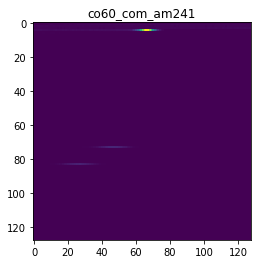

In [152]:
plt.imshow(co60_com_am241)
plt.title('co60_com_am241')
plt.show()

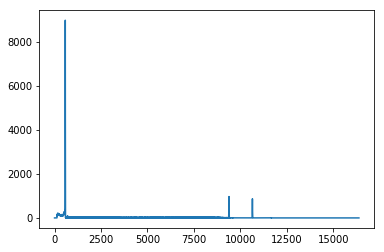

In [153]:
plt.plot(co60_com_am241.reshape((128*128)))
plt.show()

In [155]:
eu152_com_am241 = images['Eu-152'] + images['Am-241']
pred = model.predict(np.array([eu152_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
0,Am-241,100.0000%
6,Eu-152,99.3917%
5,Cs-137,0.0083%
1,Ba-133,0.0062%
9,Pb-210,0.0006%
4,Co-60,0.0000%
8,Na-22,0.0000%
3,Co-57,0.0000%
7,Mn-54,0.0000%
2,Cd-109,0.0000%


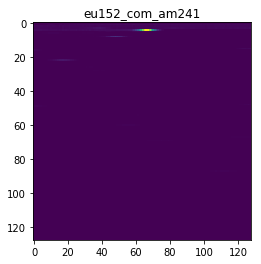

In [156]:
plt.imshow(eu152_com_am241)
plt.title('eu152_com_am241')
plt.show()

In [157]:
cs137_com_pb210 = images['Cs-137'] + images['Pb-210']

pred = model.predict(np.array([cs137_com_pb210.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
9,Pb-210,100.0000%
5,Cs-137,99.9999%
0,Am-241,0.0025%
1,Ba-133,0.0007%
6,Eu-152,0.0000%
4,Co-60,0.0000%
8,Na-22,0.0000%
3,Co-57,0.0000%
7,Mn-54,0.0000%
2,Cd-109,0.0000%


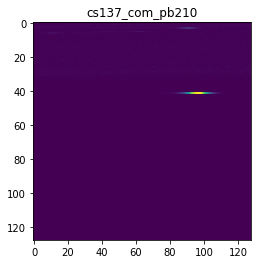

In [158]:
plt.imshow(cs137_com_pb210)
plt.title('cs137_com_pb210')
plt.show()

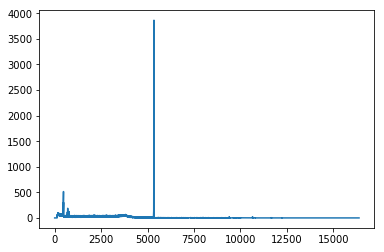

In [159]:
plt.plot(cs137_com_pb210.reshape((128*128)))
plt.show()

In [160]:
cs137_com_co60_com_am241 = images['Cs-137'] + images['Co-60'] + images['Am-241']

pred = model.predict(np.array([cs137_com_co60_com_am241.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
0,Am-241,99.9995%
5,Cs-137,99.9970%
4,Co-60,99.6868%
9,Pb-210,0.0125%
6,Eu-152,0.0022%
1,Ba-133,0.0000%
2,Cd-109,0.0000%
3,Co-57,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%


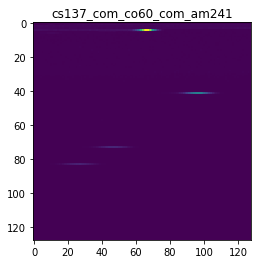

In [161]:
plt.imshow(cs137_com_co60_com_am241)
plt.title('cs137_com_co60_com_am241')
plt.show()

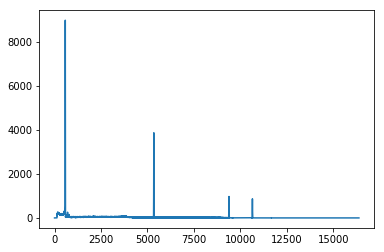

In [162]:
plt.plot(cs137_com_co60_com_am241.reshape((128*128)))
plt.show()

# Testando com a leitura de calibração (Am, Cs, Co)

Esse espectro não passou pelo treino, então é a 1a vez que a rede enxerga isso.



In [163]:
dados = []

with open('./Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

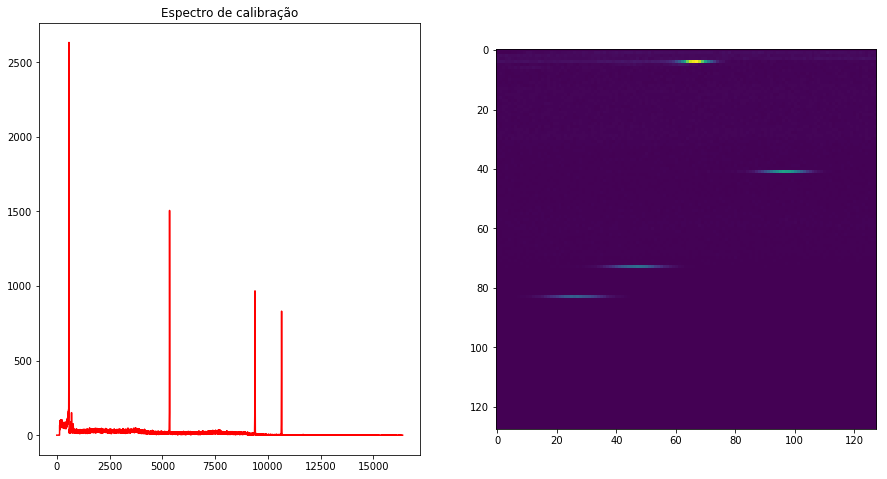

In [164]:
f, axarr = plt.subplots(1, 2, figsize=(15, 4))
axarr[0].plot(df['channel'], df['counts'], 'r')
axarr[0].set_title("Espectro de calibração")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [165]:
dados = np.array(dados)
pred = model.predict(np.array([dados.reshape((128, 128, 1))]))
df = pd.DataFrame({'radionuclideo':list(radionuclideos.keys()), 'score': pred[0]*100})
df.sort_values(by='score', ascending=False)

,radionuclideo,score
4,Co-60,100.0000%
5,Cs-137,96.7066%
0,Am-241,36.0332%
9,Pb-210,15.6357%
6,Eu-152,13.4070%
2,Cd-109,0.0028%
1,Ba-133,0.0000%
7,Mn-54,0.0000%
8,Na-22,0.0000%
3,Co-57,0.0000%
